<a href="https://colab.research.google.com/github/29Schiller/WiDS-Datathon-2025---O5-Council/blob/DuNhan/BigDataTechnologyProject_WiDSDatathon2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

In [1]:
!gdown --id 1v2CD2HYVTYVYIhQHsPUvRFuZqzpxngPd
!unzip widsdatathon2025.zip -d widsdatathon2025

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1v2CD2HYVTYVYIhQHsPUvRFuZqzpxngPd
From (redirected): https://drive.google.com/uc?id=1v2CD2HYVTYVYIhQHsPUvRFuZqzpxngPd&confirm=t&uuid=21e1360d-5d6a-4e11-9610-e086e91cbf2e
To: /content/widsdatathon2025.zip
100% 480M/480M [00:11<00:00, 41.8MB/s]
Archive:  widsdatathon2025.zip
  inflating: widsdatathon2025/Data Dictionary.xlsx  
  inflating: widsdatathon2025/SAMPLE_SUBMISSION.xlsx  
  inflating: widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx  
  inflating: widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv  
  inflating: widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx  
  inflating: widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx  
  inflating: widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METAD

# Install necessary packages

In [2]:
'''
!pip install -q umap-learn
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install scipy
!pip install -U scikit-learn
'''
!pip install pyspark
!pip install findspark
!pip install pandas

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import lightgbm as lgb, xgboost as xgb, catboost as cb
from gc import collect
import matplotlib.pyplot as plt
import umap
from matplotlib.ticker import MaxNLocator
import scipy
import seaborn as sns
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_curve, make_scorer
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest
from sklearn.linear_model import LogisticRegression, RidgeClassifier,RidgeClassifierCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE

# Set up Spark

In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DateType
import pandas as pd

# Initialize a Spark Session
spark = SparkSession\
    .builder\
    .appName("WiDSDatathon2025")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .getOrCreate()

# Check if the Spark Session is active
if 'spark' in locals() and isinstance(spark, SparkSession):
    print("SparkSession is active and ready to use.")
else:
    print("SparkSession is not active. Please create a SparkSession.")

SparkSession is active and ready to use.


# Convert from .xlsx to .csv

In [6]:
import pandas as pd
import os

# Mapping of files to be converted
excel_to_csv_map = {
    # TEST set
    "/content/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx":
        "/content/widsdatathon2025_csv/TEST/TEST_CATEGORICAL.csv",
    "/content/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx":
        "/content/widsdatathon2025_csv/TEST/TEST_QUANTITATIVE_METADATA.csv",

    # TRAIN_NEW set
    "/content/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx":
        "/content/widsdatathon2025_csv/TRAIN_NEW/TRAINING_SOLUTIONS.csv",
    "/content/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx":
        "/content/widsdatathon2025_csv/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.csv",
    "/content/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx":
        "/content/widsdatathon2025_csv/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.csv",

    # TRAIN_OLD set
    "/content/widsdatathon2025/TRAIN_OLD/TRAINING_SOLUTIONS.xlsx":
        "/content/widsdatathon2025_csv/TRAIN_OLD/TRAINING_SOLUTIONS.csv",
    "/content/widsdatathon2025/TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.xlsx":
        "/content/widsdatathon2025_csv/TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.csv",
    "/content/widsdatathon2025/TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.xlsx":
        "/content/widsdatathon2025_csv/TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.csv",
}

# Convert each Excel file to CSV
for excel_path, csv_path in excel_to_csv_map.items():
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    df = pd.read_excel(excel_path)
    df.to_csv(csv_path, index=False)

# Read and Join data

In [13]:
# Load TRAIN_NEW files
train_quant_new = spark.read.csv(
    "/content/widsdatathon2025_csv/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.csv",
    header=True,
    inferSchema=True
)
train_cate_new = spark.read.csv(
    "/content/widsdatathon2025_csv/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.csv",
    header=True,
    inferSchema=True
)
train_sol_new = spark.read.csv(
    "/content/widsdatathon2025_csv/TRAIN_NEW/TRAINING_SOLUTIONS.csv",
    header=True,
    inferSchema=True
)

# Join them together on 'participant_id'
train_df_new = train_quant_new.join(train_cate_new, on="participant_id", how="left") \
                      .join(train_sol_new, on="participant_id", how="left")
train_df_new.show(5, truncate=False)

+--------------+-------------+--------------------+--------------+--------------+---------------+---------------+--------------+--------------+------------------------+--------------------------+--------------------------+---------------------+-------------------------+---------------------+---------------------+---------------------+-----------------+---------------------+-----------------------+----------------------+--------------------------------+---------------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+------------+-----+
|participant_id|EHQ_EHQ_Total|ColorVision_CV_Score|APQ_P_APQ_P_CP|APQ_P_APQ_P_ID|APQ_P_APQ_P_INV|APQ_P_APQ_P_OPD|APQ_P_APQ_P_PM|APQ_P_APQ_P_PP|SDQ_SDQ_Conduct_Problems|SDQ_SDQ_Difficulties_Total|SDQ_SDQ_Emotional_Problems|SDQ_SDQ_Externalizing|SDQ_SDQ_Generating_Impact|SDQ_SDQ_Hyperactivity|SDQ_SDQ_Internalizing|SDQ_SDQ_Peer_Problems|SDQ_SDQ_Prosocial|MRI_Track_Age_at_Scan|Basi

['participant_id',
 'EHQ_EHQ_Total',
 'ColorVision_CV_Score',
 'APQ_P_APQ_P_CP',
 'APQ_P_APQ_P_ID',
 'APQ_P_APQ_P_INV',
 'APQ_P_APQ_P_OPD',
 'APQ_P_APQ_P_PM',
 'APQ_P_APQ_P_PP',
 'SDQ_SDQ_Conduct_Problems',
 'SDQ_SDQ_Difficulties_Total',
 'SDQ_SDQ_Emotional_Problems',
 'SDQ_SDQ_Externalizing',
 'SDQ_SDQ_Generating_Impact',
 'SDQ_SDQ_Hyperactivity',
 'SDQ_SDQ_Internalizing',
 'SDQ_SDQ_Peer_Problems',
 'SDQ_SDQ_Prosocial',
 'MRI_Track_Age_at_Scan',
 'Basic_Demos_Enroll_Year',
 'Basic_Demos_Study_Site',
 'PreInt_Demos_Fam_Child_Ethnicity',
 'PreInt_Demos_Fam_Child_Race',
 'MRI_Track_Scan_Location',
 'Barratt_Barratt_P1_Edu',
 'Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Barratt_Barratt_P2_Occ',
 'ADHD_Outcome',
 'Sex_F']

In [11]:
# Load TRAIN_OLD files
train_quant_old = spark.read.csv(
    "/content/widsdatathon2025_csv/TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.csv",
    header=True,
    inferSchema=True
)
train_cate_old = spark.read.csv(
    "/content/widsdatathon2025_csv/TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.csv",
    header=True,
    inferSchema=True
)
train_sol_old = spark.read.csv(
    "/content/widsdatathon2025_csv/TRAIN_OLD/TRAINING_SOLUTIONS.csv",
    header=True,
    inferSchema=True
)

# Join them together on 'participant_id'
train_df_old = train_quant_old.join(train_cate_old, on="participant_id", how="left") \
                      .join(train_sol_old, on="participant_id", how="left")
train_df_old.show(5, truncate=False)

+--------------+-------------+--------------------+--------------+--------------+---------------+---------------+--------------+--------------+------------------------+--------------------------+--------------------------+---------------------+-------------------------+---------------------+---------------------+---------------------+-----------------+---------------------+-----------------------+----------------------+--------------------------------+---------------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+------------+-----+
|participant_id|EHQ_EHQ_Total|ColorVision_CV_Score|APQ_P_APQ_P_CP|APQ_P_APQ_P_ID|APQ_P_APQ_P_INV|APQ_P_APQ_P_OPD|APQ_P_APQ_P_PM|APQ_P_APQ_P_PP|SDQ_SDQ_Conduct_Problems|SDQ_SDQ_Difficulties_Total|SDQ_SDQ_Emotional_Problems|SDQ_SDQ_Externalizing|SDQ_SDQ_Generating_Impact|SDQ_SDQ_Hyperactivity|SDQ_SDQ_Internalizing|SDQ_SDQ_Peer_Problems|SDQ_SDQ_Prosocial|MRI_Track_Age_at_Scan|Basi

In [15]:
print(train_df_new.columns)
print(train_df_old.columns)

['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'ADHD_Outcome', 'Sex_F']
['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ

In [16]:
train_df = train_df_old.unionByName(train_df_new)
train_df.show(5, truncate=False)

+--------------+-------------+--------------------+--------------+--------------+---------------+---------------+--------------+--------------+------------------------+--------------------------+--------------------------+---------------------+-------------------------+---------------------+---------------------+---------------------+-----------------+---------------------+-----------------------+----------------------+--------------------------------+---------------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+------------+-----+
|participant_id|EHQ_EHQ_Total|ColorVision_CV_Score|APQ_P_APQ_P_CP|APQ_P_APQ_P_ID|APQ_P_APQ_P_INV|APQ_P_APQ_P_OPD|APQ_P_APQ_P_PM|APQ_P_APQ_P_PP|SDQ_SDQ_Conduct_Problems|SDQ_SDQ_Difficulties_Total|SDQ_SDQ_Emotional_Problems|SDQ_SDQ_Externalizing|SDQ_SDQ_Generating_Impact|SDQ_SDQ_Hyperactivity|SDQ_SDQ_Internalizing|SDQ_SDQ_Peer_Problems|SDQ_SDQ_Prosocial|MRI_Track_Age_at_Scan|Basi

In [12]:
# Load TEST files
test_quant = spark.read.csv(
    "/content/widsdatathon2025_csv/TEST/TEST_QUANTITATIVE_METADATA.csv",
    header=True,
    inferSchema=True
)
test_cate = spark.read.csv(
    "/content/widsdatathon2025_csv/TEST/TEST_CATEGORICAL.csv",
    header=True,
    inferSchema=True
)

test_df = test_quant.join(test_cate, on="participant_id", how="left")
test_df.show(5, truncate=False)

+--------------+-------------+--------------------+--------------+--------------+---------------+---------------+--------------+--------------+------------------------+--------------------------+--------------------------+---------------------+-------------------------+---------------------+---------------------+---------------------+-----------------+---------------------+-----------------------+----------------------+--------------------------------+---------------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+
|participant_id|EHQ_EHQ_Total|ColorVision_CV_Score|APQ_P_APQ_P_CP|APQ_P_APQ_P_ID|APQ_P_APQ_P_INV|APQ_P_APQ_P_OPD|APQ_P_APQ_P_PM|APQ_P_APQ_P_PP|SDQ_SDQ_Conduct_Problems|SDQ_SDQ_Difficulties_Total|SDQ_SDQ_Emotional_Problems|SDQ_SDQ_Externalizing|SDQ_SDQ_Generating_Impact|SDQ_SDQ_Hyperactivity|SDQ_SDQ_Internalizing|SDQ_SDQ_Peer_Problems|SDQ_SDQ_Prosocial|MRI_Track_Age_at_Scan|Basic_Demos_Enroll_Year

# Explore the dataset to understand its structure, features, and distribution

In [22]:
print(type(train_df), "\nNumber of Rows: ", train_df.count(), "\nNumber of Columns: ", len(train_df.columns))

<class 'pyspark.sql.dataframe.DataFrame'> 
Number of Rows:  2426 
Number of Columns:  30


In [17]:
train_df.printSchema()

root
 |-- participant_id: string (nullable = true)
 |-- EHQ_EHQ_Total: double (nullable = true)
 |-- ColorVision_CV_Score: double (nullable = true)
 |-- APQ_P_APQ_P_CP: double (nullable = true)
 |-- APQ_P_APQ_P_ID: double (nullable = true)
 |-- APQ_P_APQ_P_INV: double (nullable = true)
 |-- APQ_P_APQ_P_OPD: double (nullable = true)
 |-- APQ_P_APQ_P_PM: double (nullable = true)
 |-- APQ_P_APQ_P_PP: double (nullable = true)
 |-- SDQ_SDQ_Conduct_Problems: double (nullable = true)
 |-- SDQ_SDQ_Difficulties_Total: double (nullable = true)
 |-- SDQ_SDQ_Emotional_Problems: double (nullable = true)
 |-- SDQ_SDQ_Externalizing: double (nullable = true)
 |-- SDQ_SDQ_Generating_Impact: double (nullable = true)
 |-- SDQ_SDQ_Hyperactivity: double (nullable = true)
 |-- SDQ_SDQ_Internalizing: double (nullable = true)
 |-- SDQ_SDQ_Peer_Problems: double (nullable = true)
 |-- SDQ_SDQ_Prosocial: double (nullable = true)
 |-- MRI_Track_Age_at_Scan: double (nullable = true)
 |-- Basic_Demos_Enroll_Year: i

In [19]:
from pyspark.sql.functions import col, sum, when

# Count nulls and empty strings for each column
null_counts = train_df.select([
    sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
    for c in train_df.columns
])

# Show the null counts
null_counts.show(truncate=False)

+--------------+-------------+--------------------+--------------+--------------+---------------+---------------+--------------+--------------+------------------------+--------------------------+--------------------------+---------------------+-------------------------+---------------------+---------------------+---------------------+-----------------+---------------------+-----------------------+----------------------+--------------------------------+---------------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+------------+-----+
|participant_id|EHQ_EHQ_Total|ColorVision_CV_Score|APQ_P_APQ_P_CP|APQ_P_APQ_P_ID|APQ_P_APQ_P_INV|APQ_P_APQ_P_OPD|APQ_P_APQ_P_PM|APQ_P_APQ_P_PP|SDQ_SDQ_Conduct_Problems|SDQ_SDQ_Difficulties_Total|SDQ_SDQ_Emotional_Problems|SDQ_SDQ_Externalizing|SDQ_SDQ_Generating_Impact|SDQ_SDQ_Hyperactivity|SDQ_SDQ_Internalizing|SDQ_SDQ_Peer_Problems|SDQ_SDQ_Prosocial|MRI_Track_Age_at_Scan|Basi

In [20]:
from pyspark.sql.functions import col, sum, when

# Count nulls and empty strings for each column
null_counts = test_df.select([
    sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
    for c in test_df.columns
])

# Show the null counts
null_counts.show(truncate=False)

+--------------+-------------+--------------------+--------------+--------------+---------------+---------------+--------------+--------------+------------------------+--------------------------+--------------------------+---------------------+-------------------------+---------------------+---------------------+---------------------+-----------------+---------------------+-----------------------+----------------------+--------------------------------+---------------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+
|participant_id|EHQ_EHQ_Total|ColorVision_CV_Score|APQ_P_APQ_P_CP|APQ_P_APQ_P_ID|APQ_P_APQ_P_INV|APQ_P_APQ_P_OPD|APQ_P_APQ_P_PM|APQ_P_APQ_P_PP|SDQ_SDQ_Conduct_Problems|SDQ_SDQ_Difficulties_Total|SDQ_SDQ_Emotional_Problems|SDQ_SDQ_Externalizing|SDQ_SDQ_Generating_Impact|SDQ_SDQ_Hyperactivity|SDQ_SDQ_Internalizing|SDQ_SDQ_Peer_Problems|SDQ_SDQ_Prosocial|MRI_Track_Age_at_Scan|Basic_Demos_Enroll_Year

In [18]:
train_df.describe().show()

+-------+--------------+-----------------+--------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------------+--------------------------+--------------------------+---------------------+-------------------------+---------------------+---------------------+---------------------+-----------------+---------------------+-----------------------+----------------------+--------------------------------+---------------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+------------------+-------------------+
|summary|participant_id|    EHQ_EHQ_Total|ColorVision_CV_Score|    APQ_P_APQ_P_CP|    APQ_P_APQ_P_ID|  APQ_P_APQ_P_INV|   APQ_P_APQ_P_OPD|   APQ_P_APQ_P_PM|    APQ_P_APQ_P_PP|SDQ_SDQ_Conduct_Problems|SDQ_SDQ_Difficulties_Total|SDQ_SDQ_Emotional_Problems|SDQ_SDQ_Externalizing|SDQ_SDQ_Generating_Impact|SDQ_SDQ_Hyperactivity|SDQ_

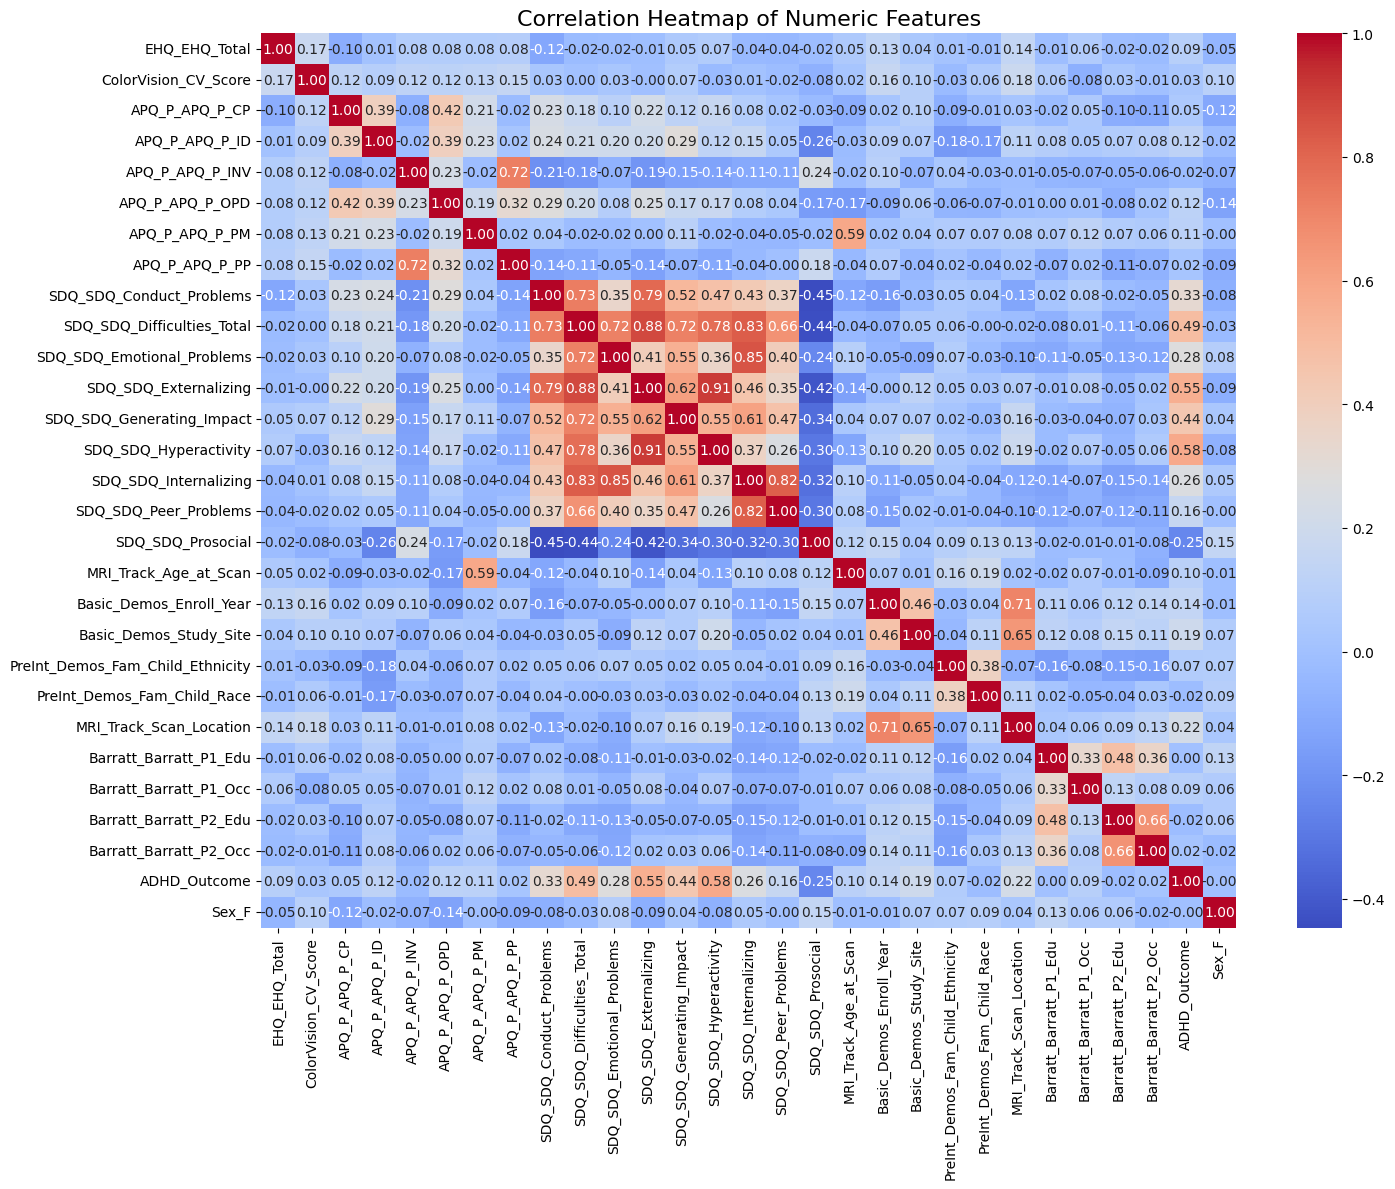

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns only
numeric_cols = [c for c, dtype in train_df.dtypes if dtype in ('int', 'double')]

# Sample and convert to pandas
# You can adjust the fraction or limit for larger datasets
sample_df = train_df.select(numeric_cols).sample(fraction=0.1, seed=42).toPandas()

# Step 3: Compute correlation matrix
corr_matrix = sample_df.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()
